In [ ]:
!pip install -qU langgraph langsmith langchain_anthropic langchain langchain-community tavily-python openai

# Build a Customer Support Bot

## Setup

In [ ]:
import os

os.environ["ANTHROPIC_API_KEY"] = "YOUR_ANTHROPIC_API_KEY"
os.environ['TAVILY_API_KEY'] = 'YOUR_TAVILY_API_KEY'
os.environ['OPENAI_API_KEY'] = 'YOUR_OPENAI_API_KEY'

### Populate the database

The following script fetches a `sqlite` database that is used in this section.

In [3]:
import os
import shutil
import sqlite3

import pandas as pd
import requests

db_url = "https://storage.googleapis.com/benchmarks-artifacts/travel-db/travel2.sqlite"
local_file = 'travel2.sqlite'
# The backup let us restart for each tutorial section
backup_file = 'travel2.backup.sqlite'
overwrite = False
if overwrite or not os.path.exists(local_file):
    response = requests.get(db_url)
    response.raise_for_status() # ensure the request was successful
    with open(local_file, 'wb') as f:
        f.write(response.content)
    # backup - we will use this to "reset" our database in each section
    shutil.copy(local_file, backup_file)


# Covert the flights to present time
def update_dates(file):
    shutil.copy(backup_file, file)
    conn = sqlite3.connect(file)
    cursor = conn.cursor()

    tables = pd.read_sql(
        "SELECT name FROM sqlite_master WHERE type='table';",
        conn,
    ).name.tolist()

    tdf = {}
    for t in tables:
        tdf[t] = pd.read_sql(f"SELECT * FROM {t}", conn)

    example_time = pd.to_datetime(
        tdf['flights']['actual_departure'].replace("\\N", pd.NaT)
    ).max()
    current_time = pd.to_datetime('now').tz_localize(example_time.tz)
    time_diff = current_time - example_time

    tdf['bookings']['book_date'] = (
        pd.to_datetime(tdf['bookings']['book_date'].replace('\\N', pd.NaT), utc=True)
        + time_diff
    )

    datetime_columns = [
        'scheduled_departure',
        'scheduled_arrival',
        'actual_departure',
        'actual_arrival',
    ]
    for column in datetime_columns:
        tdf['flights'][column] = (
            pd.to_datetime(tdf['flights'][column].replace('\\N', pd.NaT)) + time_diff
        )

    for table_name, df in tdf.items():
        df.to_sql(table_name, conn, if_exists='replace', index=False)

    del df
    del tdf
    conn.commit()
    conn.close()

    return file


db = update_dates(local_file)

# Tools

Next, we define our assistant's tools to search the airline's policy manual and search and manage reservations for flights, hotels, car rentals, and excursions.

## Lookup compnay policies

The assitant retriee policy information to answer user questions. Note that *enforcement* of these policies still must be done within the tools/APIs themselves, since the LLM can always ignore this.

In [4]:
import re
import numpy as np
import openai
from langchain_core.tools import tool

response = requests.get(
    "https://storage.googleapis.com/benchmarks-artifacts/travel-db/swiss_faq.md"
)
response.raise_for_status()
faq_text = response.text

docs = [
    {'page_content': txt} for txt in re.split(r"(?=\n##)", faq_text)
]

In [5]:
class VectorStoreRetriever:
    def __init__(self, docs: list, vectors: list, oai_client):
        self._arr = np.array(vectors)
        self._docs = docs
        self._client = oai_client

    @classmethod
    def from_docs(cls, docs, oai_client):
        embeddings = oai_client.embeddings.create(
            model='text-embedding-3-small',
            input=[doc['page_content'] for doc in docs]
        )
        vectors = [emb.embedding for emb in embeddings.data]

        return cls(docs, vectors, oai_client)

    def query(self, query: str, k: int = 5) -> list[dict]:
        embed = self._client.embeddings.create(
            model='text-embedding-3-small',
            input=[query]
        )
        # `@` for matrix multiplication
        scores = np.array(embed.data[0].embedding) @ self._arr.T
        top_k_idx = np.argpartition(scores, -k)[-k:]
        top_k_idx_sorted = top_k_idx[np.argsort(-scores[top_k_idx])]

        return [
            {**self._docs[idx], 'similarity': scores[idx]} for idx in top_k_idx_sorted
        ]



retriever = VectorStoreRetriever.from_docs(docs, openai.Client())

In [6]:
@tool
def lookup_policy(query: str) -> str:
    """
    Consult the company policies to check whether certain options are permitted.
    Use this before making any flight changes performing other 'write' events.
    """
    docs = retriever.query(query, k=2)
    return "\n\n".join([doc['page_content'] for doc in docs])

## Flights

Define the `fetch_user_flight_information` tool to let the agent see the current user's flight information. Then define tools to search for flights and manage the passengers's bookings stored in the SQL database.

We can access the `RunnableConfig` for a given run to check the `passenger_id` of the user accessing this application. The LLM never has to provide these explicitly, they are provided for a given invocation of the graph so that each user cannot access other passengers' booking information.

In [7]:
import sqlite3
from datetime import date, datetime
from typing import Optional

import pytz
from langchain_core.runnables import RunnableConfig


@tool
def fetch_user_flight_information(config: RunnableConfig) -> list[dict]:
    """
    Fetch all tickets for the user along with corresponding flight information and seat assignments.

    Returns:
        A list of dictionaries where each dictionary contains the ticket details,
        associated flight details, and the seat assignments for each ticket belonging to the user.
    """
    configuration = config.get('configurable', {})
    passenger_id = configuration.get('passenger_id', None)
    if not passenger_id:
        raise ValueError('No passenger ID configured.')

    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    query = """
    SELECT
        t.ticket_no, t.book_ref,
        f.flight_id, f.flight_no, f.departure_airport, f.arrival_airport, f.scheduled_departure, f.scheduled_arrival,
        bp.seat_no, tf.fare_conditions
    FROM
        tickets t
        JOIN ticket_flights tf ON t.ticket_no = tf.ticket_no
        JOIN flights f ON tf.flight_id = f.flight_id
        JOIN boarding_passes bp ON bp.ticket_no = t.ticket_no AND bp.flight_id = f.flight_id
    WHERE
        t.passenger_id = ?
    """

    cursor.execute(query, (passenger_id,))
    rows = cursor.fetchall()
    column_names = [column[0] for column in cursor.description]
    results = [dict(zip(column_names, row)) for row in rows]

    cursor.close()
    conn.close()

    return results


@tool
def search_flights(
        departure_airport: Optional[str] = None,
        arrival_airport: Optional[str] = None,
        start_time: Optional[date | datetime] = None,
        end_time: Optional[date | datetime] = None,
        limit: int = 20,
) -> list[dict]:
    """Search for flights based on departure airport, arrival airport, and departure time range."""
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    query = "SELECT * FROM flights WHERE 1=1"
    params = []

    if departure_airport:
        query += " AND departure_airport = ?"
        params.append(departure_airport)

    if arrival_airport:
        query += " AND arrival_airport = ?"
        params.append(arrival_airport)

    if start_time:
        query += " AND scheduled_departure >= ?"
        params.append(start_time)

    if end_time:
        query += " AND scheduled_departure <= ?"
        params.append(end_time)

    query += " LIMIT ?"
    params.append(limit)
    cursor.execute(query, params)
    rows = cursor.fetchall()
    column_names = [column[0] for column in cursor.description]
    results = [dict(zip(column_names, row)) for row in rows]

    cursor.close()
    conn.close()

    return results


@tool
def update_ticket_to_new_flight(
        ticket_no: str,
        new_flight_id: int,
        *,
        config: RunnableConfig,
) -> str:
    """Update the user's ticket to a new valid flight."""
    configuration = config.get('configurable', {})
    passenger_id = configuration.get('passenger_id', None)
    if not passenger_id:
        raise ValueError('No passenger ID configured.')

    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute(
        "SELECT departure_airport, arrival_airport, scheduled_departure FROM flights WHERE flight_id = ?",
        (new_flight_id,),
    )
    new_flight = cursor.fetchone()
    if not new_flight:
        cursor.close()
        conn.close()
        return "Invalid new flight ID provided."

    column_names = [column[0] for column in cursor.description]
    new_flight_dict = dict(zip(column_names, new_flight))
    timezone = pytz.timezone('Etc/GMT-3')
    current_time = datetime.now(tz=timezone)
    departure_time = datetime.strptime(
        new_flight_dict["scheduled_departure"], "%Y-%m-%d %H:%M:%S.%f%z"
    )
    time_until = (departure_time - current_time).total_seconds()
    if time_until < (3 * 3600):
        return f"Not permitted to reschedule to a flight that is less than 3 hours from the current time. Selected flight is at {departure_time}."

    cursor.execute(
        "SELECT flight_id FROM ticket_flights WHERE ticket_no = ?", (ticket_no,)
    )
    current_flight = cursor.fetchone()
    if not current_flight:
        cursor.close()
        conn.close()
        return "No existing ticket found for the given ticket number."

    # Check the signed-in user actually has this ticket
    cursor.execute(
        "SELECT * FROM tickets WHERE ticket_no = ? AND passenger_id = ?",
        (ticket_no, passenger_id),
    )
    current_ticket = cursor.fetchone()
    if not current_ticket:
        cursor.close()
        conn.close()
        return f"Current signed-in passenger with ID {passenger_id} not the owner of ticket {ticket_no}"

    # In a real application, you'd likely add additional checks here to enforce business logic,
    # like "does the new departure airport match the current ticket", etc.
    # While it's best to try to be *proactive* in 'type-hinting' policies to the LLM
    # it's inevitably going to get things wrong, so you **also** need to ensure your
    # API enforces valid behavior
    cursor.execute(
        "UPDATE ticket_flights SET flight_id = ? WHERE ticket_no = ?",
        (new_flight_id, ticket_no),
    )
    conn.commit()

    cursor.close()
    conn.close()
    return "Ticket successfully updated to new flight."


@tool
def cancel_ticket(ticket_no: str, *, config: RunnableConfig) -> str:
    """Cancel the user's ticket and remove it from the database."""
    configuration = config.get("configurable", {})
    passenger_id = configuration.get("passenger_id", None)
    if not passenger_id:
        raise ValueError("No passenger ID configured.")
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute(
        "SELECT flight_id FROM ticket_flights WHERE ticket_no = ?", (ticket_no,)
    )
    existing_ticket = cursor.fetchone()
    if not existing_ticket:
        cursor.close()
        conn.close()
        return "No existing ticket found for the given ticket number."

    # Check the signed-in user actually has this ticket
    cursor.execute(
        "SELECT flight_id FROM tickets WHERE ticket_no = ? AND passenger_id = ?",
        (ticket_no, passenger_id),
    )
    current_ticket = cursor.fetchone()
    if not current_ticket:
        cursor.close()
        conn.close()
        return f"Current signed-in passenger with ID {passenger_id} not the owner of ticket {ticket_no}"

    cursor.execute("DELETE FROM ticket_flights WHERE ticket_no = ?", (ticket_no,))
    conn.commit()

    cursor.close()
    conn.close()
    return "Ticket successfully cancelled."

## Car rental tools

Once a user books a flight, they likely will want to organize transportation.

In [8]:
from datetime import date, datetime
from typing import Optional, Union


@tool
def search_car_rentals(
    location: Optional[str] = None,
    name: Optional[str] = None,
    price_tier: Optional[str] = None,
    start_date: Optional[Union[datetime, date]] = None,
    end_date: Optional[Union[datetime, date]] = None,
) -> list[dict]:
    """
    Search for car rentals based on location, name, price tier, start date, and end date.

    Args:
        location (Optional[str]): The location of the car rental. Defaults to None.
        name (Optional[str]): The name of the car rental company. Defaults to None.
        price_tier (Optional[str]): The price tier of the car rental. Defaults to None.
        start_date (Optional[Union[datetime, date]]): The start date of the car rental. Defaults to None.
        end_date (Optional[Union[datetime, date]]): The end date of the car rental. Defaults to None.

    Returns:
        list[dict]: A list of car rental dictionaries matching the search criteria.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    query = "SELECT * FROM car_rentals WHERE 1=1"
    params = []

    if location:
        query += " AND location LIKE ?"
        params.append(f"%{location}%")
    if name:
        query += " AND name LIKE ?"
        params.append(f"%{name}%")
    # For our tutorial, we will let you match on any dates and price tier.
    # (since our toy dataset doesn't have much data)
    cursor.execute(query, params)
    results = cursor.fetchall()

    conn.close()

    return [
        dict(zip([column[0] for column in cursor.description], row)) for row in results
    ]


@tool
def book_car_rental(rental_id: int) -> str:
    """
    Book a car rental by its ID.

    Args:
        rental_id (int): The ID of the car rental to book.

    Returns:
        str: A message indicating whether the car rental was successfully booked or not.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute("UPDATE car_rentals SET booked = 1 WHERE id = ?", (rental_id,))
    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Car rental {rental_id} successfully booked."
    else:
        conn.close()
        return f"No car rental found with ID {rental_id}."


@tool
def update_car_rental(
    rental_id: int,
    start_date: Optional[Union[datetime, date]] = None,
    end_date: Optional[Union[datetime, date]] = None,
) -> str:
    """
    Update a car rental's start and end dates by its ID.

    Args:
        rental_id (int): The ID of the car rental to update.
        start_date (Optional[Union[datetime, date]]): The new start date of the car rental. Defaults to None.
        end_date (Optional[Union[datetime, date]]): The new end date of the car rental. Defaults to None.

    Returns:
        str: A message indicating whether the car rental was successfully updated or not.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    if start_date:
        cursor.execute(
            "UPDATE car_rentals SET start_date = ? WHERE id = ?",
            (start_date, rental_id),
        )
    if end_date:
        cursor.execute(
            "UPDATE car_rentals SET end_date = ? WHERE id = ?", (end_date, rental_id)
        )

    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Car rental {rental_id} successfully updated."
    else:
        conn.close()
        return f"No car rental found with ID {rental_id}."


@tool
def cancel_car_rental(rental_id: int) -> str:
    """
    Cancel a car rental by its ID.

    Args:
        rental_id (int): The ID of the car rental to cancel.

    Returns:
        str: A message indicating whether the car rental was successfully cancelled or not.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute("UPDATE car_rentals SET booked = 0 WHERE id = ?", (rental_id,))
    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Car rental {rental_id} successfully cancelled."
    else:
        conn.close()
        return f"No car rental found with ID {rental_id}."

## Hotels

In [9]:
@tool
def search_hotels(
    location: Optional[str] = None,
    name: Optional[str] = None,
    price_tier: Optional[str] = None,
    checkin_date: Optional[Union[datetime, date]] = None,
    checkout_date: Optional[Union[datetime, date]] = None,
) -> list[dict]:
    """
    Search for hotels based on location, name, price tier, check-in date, and check-out date.

    Args:
        location (Optional[str]): The location of the hotel. Defaults to None.
        name (Optional[str]): The name of the hotel. Defaults to None.
        price_tier (Optional[str]): The price tier of the hotel. Defaults to None. Examples: Midscale, Upper Midscale, Upscale, Luxury
        checkin_date (Optional[Union[datetime, date]]): The check-in date of the hotel. Defaults to None.
        checkout_date (Optional[Union[datetime, date]]): The check-out date of the hotel. Defaults to None.

    Returns:
        list[dict]: A list of hotel dictionaries matching the search criteria.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    query = "SELECT * FROM hotels WHERE 1=1"
    params = []

    if location:
        query += " AND location LIKE ?"
        params.append(f"%{location}%")
    if name:
        query += " AND name LIKE ?"
        params.append(f"%{name}%")
    # For the sake of this tutorial, we will let you match on any dates and price tier.
    cursor.execute(query, params)
    results = cursor.fetchall()

    conn.close()

    return [
        dict(zip([column[0] for column in cursor.description], row)) for row in results
    ]


@tool
def book_hotel(hotel_id: int) -> str:
    """
    Book a hotel by its ID.

    Args:
        hotel_id (int): The ID of the hotel to book.

    Returns:
        str: A message indicating whether the hotel was successfully booked or not.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute("UPDATE hotels SET booked = 1 WHERE id = ?", (hotel_id,))
    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Hotel {hotel_id} successfully booked."
    else:
        conn.close()
        return f"No hotel found with ID {hotel_id}."


@tool
def update_hotel(
    hotel_id: int,
    checkin_date: Optional[Union[datetime, date]] = None,
    checkout_date: Optional[Union[datetime, date]] = None,
) -> str:
    """
    Update a hotel's check-in and check-out dates by its ID.

    Args:
        hotel_id (int): The ID of the hotel to update.
        checkin_date (Optional[Union[datetime, date]]): The new check-in date of the hotel. Defaults to None.
        checkout_date (Optional[Union[datetime, date]]): The new check-out date of the hotel. Defaults to None.

    Returns:
        str: A message indicating whether the hotel was successfully updated or not.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    if checkin_date:
        cursor.execute(
            "UPDATE hotels SET checkin_date = ? WHERE id = ?", (checkin_date, hotel_id)
        )
    if checkout_date:
        cursor.execute(
            "UPDATE hotels SET checkout_date = ? WHERE id = ?",
            (checkout_date, hotel_id),
        )

    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Hotel {hotel_id} successfully updated."
    else:
        conn.close()
        return f"No hotel found with ID {hotel_id}."


@tool
def cancel_hotel(hotel_id: int) -> str:
    """
    Cancel a hotel by its ID.

    Args:
        hotel_id (int): The ID of the hotel to cancel.

    Returns:
        str: A message indicating whether the hotel was successfully cancelled or not.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute("UPDATE hotels SET booked = 0 WHERE id = ?", (hotel_id,))
    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Hotel {hotel_id} successfully cancelled."
    else:
        conn.close()
        return f"No hotel found with ID {hotel_id}."

## Excursions

In [10]:
@tool
def search_trip_recommendations(
    location: Optional[str] = None,
    name: Optional[str] = None,
    keywords: Optional[str] = None,
) -> list[dict]:
    """
    Search for trip recommendations based on location, name, and keywords.

    Args:
        location (Optional[str]): The location of the trip recommendation. Defaults to None.
        name (Optional[str]): The name of the trip recommendation. Defaults to None.
        keywords (Optional[str]): The keywords associated with the trip recommendation. Defaults to None.

    Returns:
        list[dict]: A list of trip recommendation dictionaries matching the search criteria.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    query = "SELECT * FROM trip_recommendations WHERE 1=1"
    params = []

    if location:
        query += " AND location LIKE ?"
        params.append(f"%{location}%")
    if name:
        query += " AND name LIKE ?"
        params.append(f"%{name}%")
    if keywords:
        keyword_list = keywords.split(",")
        keyword_conditions = " OR ".join(["keywords LIKE ?" for _ in keyword_list])
        query += f" AND ({keyword_conditions})"
        params.extend([f"%{keyword.strip()}%" for keyword in keyword_list])

    cursor.execute(query, params)
    results = cursor.fetchall()

    conn.close()

    return [
        dict(zip([column[0] for column in cursor.description], row)) for row in results
    ]


@tool
def book_excursion(recommendation_id: int) -> str:
    """
    Book a excursion by its recommendation ID.

    Args:
        recommendation_id (int): The ID of the trip recommendation to book.

    Returns:
        str: A message indicating whether the trip recommendation was successfully booked or not.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute(
        "UPDATE trip_recommendations SET booked = 1 WHERE id = ?", (recommendation_id,)
    )
    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Trip recommendation {recommendation_id} successfully booked."
    else:
        conn.close()
        return f"No trip recommendation found with ID {recommendation_id}."


@tool
def update_excursion(recommendation_id: int, details: str) -> str:
    """
    Update a trip recommendation's details by its ID.

    Args:
        recommendation_id (int): The ID of the trip recommendation to update.
        details (str): The new details of the trip recommendation.

    Returns:
        str: A message indicating whether the trip recommendation was successfully updated or not.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute(
        "UPDATE trip_recommendations SET details = ? WHERE id = ?",
        (details, recommendation_id),
    )
    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Trip recommendation {recommendation_id} successfully updated."
    else:
        conn.close()
        return f"No trip recommendation found with ID {recommendation_id}."


@tool
def cancel_excursion(recommendation_id: int) -> str:
    """
    Cancel a trip recommendation by its ID.

    Args:
        recommendation_id (int): The ID of the trip recommendation to cancel.

    Returns:
        str: A message indicating whether the trip recommendation was successfully cancelled or not.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute(
        "UPDATE trip_recommendations SET booked = 0 WHERE id = ?", (recommendation_id,)
    )
    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Trip recommendation {recommendation_id} successfully cancelled."
    else:
        conn.close()
        return f"No trip recommendation found with ID {recommendation_id}."

## Utilities

Define helper functions to pretty print the messages in the graph while we debug it and to give our tool node error handling.

In [11]:
from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda

from langgraph.prebuilt import ToolNode


def handle_tool_error(state) -> dict:
    error = state.get('error')
    tool_calls = state['messages'][-1].tool_calls

    return {
        'messages': [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix the error.",
                tool_call_id=tc['id'],
            )
            for tc in tool_calls
        ]
    }


def create_tool_node_with_fallback(tools: list) -> dict:
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)],
        exception_key='error',
    )


def _print_event(event: dict, _printed: set, max_length=1500):
    current_state = event.get('dialog_state')
    if current_state:
        print('Currently in: ', current_state[-1])

    message = event.get('messages')
    if message:
        if isinstance(message, list):
            message = message[-1]
        if message.id not in _printed:
            msg_repr = message.pretty_repr(html=True)
            if len(msg_repr) > max_length:
                msg_repr = msg_repr[:max_length] + " ... (truncated)"
            print(msg_repr)
            _printed.add(message.id)

# Zero-shot Agent

When building agents, it is best to start with the simplest working implementation and use an evaluation tool like LangSmith to measure its efficacy. In this section, we will define a simple Zero-shot agent as the assistant, give the agent all of our tools defined above, and prompt it to use them to assist the user.

## State

Define our `StateGraph`'s state as a typed dictionary containing an append-only list of messages. These messages form the chat history, which is all the state our simple assistant needs.

In [ ]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph.message import AnyMessage, add_messages


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

## Agent

Next, we define the assitant function, which takes the graph state, formats it into a prompt, and then calls an LLM for it to predict the best response.

In [ ]:
from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig


class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            configuration = config.get('configurable', {})
            passenger_id = configuration.get('passenger_id', None)
            state = {**state, 'user_info': passenger_id}
            result = self.runnable.invoke(state)

            # If LLM happens to return an empty response, we will re-prompt it
            # for an actual response.
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get('text')
            ):
                messages = state['messages'] + [('user', "Response with a real output.")]
                state = {**state, 'messages': messages}
            else:
                break

        return {'messages': result}

In [ ]:
# LLM
# Kaiku is faster and cheaper, but less accurate
#llm = ChatAnthropic(model='claude-3-haiku-20240307')
llm = ChatAnthropic(model='claude-3-sonnet-20240229', temperature=1)
# from langchain_openai import ChatOpenAI
#llm = ChatOpenAI(model='gpt-4-turbo-preview')


# Prompt
primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            'system',
            "You are a helpful customer support assistant for Swiss Airlines."
            " Use the provided tools to search for flights, company policies, and other information to assist the user's queries. "
            " When searching, be persistent. Expand your query bounds if the first search returns no results. "
            " If a search comes up empty, expand your search before giving up."
            "\n\nCurrent user:\n<User>\n{user_info}\n</User>"
            "\nCurrent time: {time}."
        ),
        (
            'placeholder',
            "{messages}"
        )
    ]
).partial(time=datetime.now)

In [ ]:
# Tools
pt1_tools = [
    TavilySearchResults(max_results=1),
    fetch_user_flight_information,
    search_flights,
    lookup_policy,
    update_ticket_to_new_flight,
    cancel_ticket,
    search_car_rentals,
    book_car_rental,
    update_car_rental,
    cancel_car_rental,
    search_hotels,
    book_hotel,
    update_hotel,
    cancel_hotel,
    search_trip_recommendations,
    book_excursion,
    update_excursion,
    cancel_excursion,
]

# Runnable
pt1_assistant_runnable = primary_assistant_prompt | llm.bind_tools(tools=pt1_tools)

## Define Graph

Now we need to create the graph. The graph is the final assistant for this section.

In [ ]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import tools_condition


builder = StateGraph(State)

# Define nodes (nodes actually do the work)
builder.add_node('assistant', Assistant(pt1_assistant_runnable))
builder.add_node('tools', create_tool_node_with_fallback(pt1_tools))

# Define edges (edges determine how the control flow moves)
builder.add_edge(START, 'assistant')
builder.add_conditional_edges(
    'assistant',
    tools_condition,
)
builder.add_edge('tools', 'assistant')

# Create a checkpointer to persist its state.
# This is a complete memory for the entire graph.
memory = MemorySaver()
pt1_graph = builder.compile(checkpointer=memory)

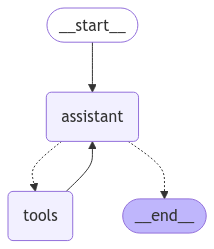

In [ ]:
from IPython.display import Image, display

display(Image(
    pt1_graph.get_graph(xray=True).draw_mermaid_png()
))

## Example Conversation

Now we focus on the chatbot:

In [ ]:
import shutil
import uuid


# Let's create an example conversation a user might have with the assistant
tutorial_questions = [
    "Hi there, what time is my flight?"
    "Am i allowed to update my flight to something sooner? I want to leave later today.",
    "Update my flight to sometime next week then",
    "The next available option is great",
    "what about lodging and transportation?",
    "Yeah i think i'd like an affordable hotel for my week-long stay (7 days). And I'll want to rent a car.",
    "OK could you place a reservation for your recommended hotel? It sounds nice.",
    "yes go ahead and book anything that's moderate expense and has availability.",
    "Now for a car, what are my options?",
    "Awesome let's just get the cheapest option. Go ahead and book for 7 days",
    "Cool so now what recommendations do you have on excursions?",
    "Are they available while I'm there?",
    "interesting - i like the museums, what options are there? ",
    "OK great pick one and book it for my second day there.",
]

# Update with the backup file so we can restart from the original place in each section
db = update_dates(db)
thread_id = str(uuid.uuid4())
config = {
    'configurable': {
        # passenger_id is used in our flight tools to
        # fetch the user's flight information
        'passenger_id': '3442 587242',
        # Checkpoints are accessed by thread_id
        'thread_id': thread_id,
    }
}

_printed = set()
for question in tutorial_questions:
    events = pt1_graph.stream(
        {'messages': ('user', question)},
        config,
        stream_mode='values',
    )

    for event in events:
        _print_event(event, _printed)

================================ Human Message =================================

Hi there, what time is my flight?Am i allowed to update my flight to something sooner? I want to leave later today.
================================== Ai Message ==================================

[{'text': "Okay, let me look up your flight details to check the scheduled departure time and see if you're allowed to change it.", 'type': 'text'}, {'id': 'toolu_016RJkhV79oux38L7Va958ms', 'input': {}, 'name': 'fetch_user_flight_information', 'type': 'tool_use'}]
Tool Calls:
  fetch_user_flight_information (toolu_016RJkhV79oux38L7Va958ms)
 Call ID: toolu_016RJkhV79oux38L7Va958ms
  Args:
================================= Tool Message =================================
Name: fetch_user_flight_information

[{"ticket_no": "7240005432906569", "book_ref": "C46E9F", "flight_id": 19250, "flight_no": "LX0112", "departure_airport": "CDG", "arrival_airport": "BSL", "scheduled_departure": "2024-11-14 20:52:50.688558-04:00"

# Add Confirmation

When an assistant takes actions on behalf of the user, the user should always have the final say on whether to follow through with the action. Otherwise, any small mistake the assistant makes can cause real damage to the user.

In this section, we will use `interrupt_before` to pause the graph to return control to the user before executing any of the tools.

## State & Assistant

Our graph state and LLM calling is nearly identical to Part 1:
* Adding a `user_info` field that will be eagerly populated by our graph.
* Using the state directly in the `Assistant` object rather than using the configurable params.

In [ ]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig
from typing_extensions import TypedDict

from langgraph.graph.message import AnyMessage, add_messages


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    user_info: str


class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            result = self.runnable.invoke(state)
            # If LLM returns an empty response, we will re-prompt it for actual response
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get('text')
            ):
                messages = state['messages'] + [('user', 'Respond with a real output.')]
                state = {**state, 'messages': messages}
            else:
                break

        return {'messages': result}

In [ ]:
llm = ChatAnthropic(model='claude-3-sonnet-20240229', temperature=1)

assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            'system',
            "You are a helpful customer support assistant for Swiss Airlines. "
            " Use the provided tools to search for flights, company policies, and other information to assist the user's queries. "
            " When searching, be persistent. Expand your query bounds if the first search returns no results. "
            " If a search comes up empty, expand your search before giving up."
            "\n\nCurrent user:\n<User>\n{user_info}\n</User>"
            "\nCurrent time: {time}.",
        ),
        (
            'placeholder',
            "{messages}",
        )
    ]
).partial(time=datetime.now)


pt2_tools = [
    TavilySearchResults(max_results=1),
    fetch_user_flight_information,
    search_flights,
    lookup_policy,
    update_ticket_to_new_flight,
    cancel_ticket,
    search_car_rentals,
    book_car_rental,
    update_car_rental,
    cancel_car_rental,
    search_hotels,
    book_hotel,
    update_hotel,
    cancel_hotel,
    search_trip_recommendations,
    book_excursion,
    update_excursion,
    cancel_excursion,
]

pt2_assistant_runnable = assistant_prompt | llm.bind_tools(tools=pt2_tools)

## Define Graph

Create the graph by making 2 changes from part 1:
* add an interrupt before using a tool
* explicitly populate the user state within the first node so the assistant does not have to use a tool just to learn about the user.

In [ ]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import tools_condition

builder = StateGraph(State)


def user_info(state: State):
    return {'user_info': fetch_user_flight_information.invoke({})}


# NEW:
# The `fetch_user_info` node runs first, meaning out assistant can see the user's flight information without
# having to take an action
builder.add_node('fetch_user_info', user_info)
builder.add_edge(START, 'fetch_user_info')
builder.add_node('assistant', Assistant(pt2_assistant_runnable))
builder.add_node('tools', create_tool_node_with_fallback(pt2_tools))
builder.add_edge('fetch_user_info', 'assistant')
builder.add_conditional_edges(
    'assistant',
    tools_condition,
)
builder.add_edge('tools', 'assistant')


memory = MemorySaver()
pt2_graph = builder.compile(
    checkpointer=memory,
    # NEW:
    # The graph will always halt before executing the "tools" node.
    # The user can approve or reject (or even alter the request) before
    # the assistant continues
    interrupt_before=['tools'],
)

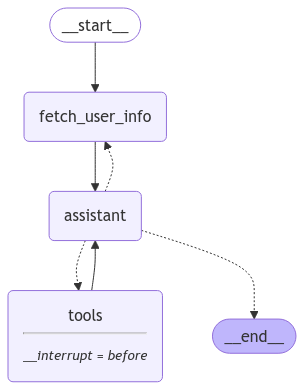

In [ ]:
from IPython.display import Image, display

display(Image(
    pt2_graph.get_graph(xray=True).draw_mermaid_png()
))

## Example Conversation

In [ ]:
import shutil
import uuid

# Update with the backup file so we can restart from the original place in each section
db = update_dates(db)
thread_id = str(uuid.uuid4())
config = {
    'configurable': {
        'passenger_id': '3442 587242',
        'thread_id': thread_id,
    }
}

_printed = set()
# Reuse the tutorial questions from part 1
for question in tutorial_questions:
    events = pt2_graph.stream(
        {'messages': ('user', question)},
        config,
        stream_mode='values',
    )
    for event in events:
        _print_event(event, _printed)

    snapshot = pt2_graph.get_state(config)
    while snapshot.next:
        # We have an interrupt!
        # The agent is trying to use a tool, and the user can approve or deny it.
        # NOTE: This code is all outside of our graph. Typically, we would
        # stream the output to a UI.
        # Then, we would have the frontend trigger a new run via an API call
        # when user has provided input.
        try:
            user_input = input(
                "Do you approve of the above actions? Type 'y' to continue;"
                " otherwise, explain your requested changes.\n\n"
            )
        except:
            user_input = 'y'

        if user_input.strip() == 'y':
            # Just continue
            result = pt2_graph.invoke(
                None,
                config,
            )
        else:
            # Satisfy the tool invocation by
            # providing instructions on the requested changes / change of mind
            result = pt2_graph.invoke(
                {
                    'messages': [
                        ToolMessage(
                            tool_call_id=event['messages'][-1].tool_calls[0]['id'],
                            content=f"API call denied by user. Reasoning: '{user_input}'. Continue assisting, accounting for the user's input."
                        )
                    ]
                },
                config,
            )

        snapshot = pt2_graph.get_state(config)

================================ Human Message =================================

Hi there, what time is my flight?Am i allowed to update my flight to something sooner? I want to leave later today.
================================== Ai Message ==================================

[{'id': 'toolu_017wC1qM3dq2oRzFWSAQMGRf', 'input': {}, 'name': 'fetch_user_flight_information', 'type': 'tool_use'}]
Tool Calls:
  fetch_user_flight_information (toolu_017wC1qM3dq2oRzFWSAQMGRf)
 Call ID: toolu_017wC1qM3dq2oRzFWSAQMGRf
  Args:
Do you approve of the above actions? Type 'y' to continue; otherwise, explain your requested changes.

y
Do you approve of the above actions? Type 'y' to continue; otherwise, explain your requested changes.

y
Do you approve of the above actions? Type 'y' to continue; otherwise, explain your requested changes.

y
Do you approve of the above actions? Type 'y' to continue; otherwise, explain your requested changes.

y
================================ Human Message ==========

Now our assistant was able to save a step to respond with our flight details. We also completely controlled which actions were performed. This all worked using LangGraph's `interrupts` and `checkpointers`.

# Conditional Interrupt

In this section, we will refine our interrupt strategy by categorizing tools as safe (read-only) or sensitie (data-modifying). We will apply interrupts to the sensitive tools only, allowing the bot to handle simple queries autonomously.

This balances user control and conversational flow.

## State

In [14]:
# Start by defining the graph state. SAME AS Pt2
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig
from typing_extensions import TypedDict

from langgraph.graph.message import AnyMessage, add_messages


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    user_info: str


class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            result = self.runnable.invoke(state)
            # If LLM returns an empty response, re-prompt it for an actual response
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get('text')
            ):
                messages = state['messages'] + [('user', "Respond with a real output.")]
                state = {**state, 'messages': messages}
            else:
                break
        return {'messages': result}


llm = ChatAnthropic(model='claude-3-sonnet-20240229', temperature=1)

assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful customer support assistant for Swiss Airlines. "
            " Use the provided tools to search for flights, company policies, and other information to assist the user's queries. "
            " When searching, be persistent. Expand your query bounds if the first search returns no results. "
            " If a search comes up empty, expand your search before giving up."
            "\n\nCurrent user:\n<User>\n{user_info}\n</User>"
            "\nCurrent time: {time}.",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now)

Define two sets of tools:

In [15]:
# "Read-only" tools (such as retrievers)
# don't need a user confirmation to use
pt3_safe_tools = [
    TavilySearchResults(max_results=1),
    fetch_user_flight_information,
    search_flights,
    lookup_policy,
    search_car_rentals,
    search_hotels,
    search_trip_recommendations,
]

# These tools change the user's reservations.
# The user has the right to control what decisions are made
pt3_sensitive_tools = [
    update_ticket_to_new_flight,
    cancel_ticket,
    book_car_rental,
    update_car_rental,
    book_hotel,
    update_hotel,
    cancel_hotel,
    book_excursion,
    update_excursion,
    cancel_excursion,
]
sensitive_tool_names = {t.name for t in pt3_sensitive_tools}

# Our LLM does not have to know which nodes it has to route to.
# It is just invoking functions
pt3_assistant_runnable = assistant_prompt | llm.bind_tools(
    tools = pt3_safe_tools + pt3_sensitive_tools
)

## Define Graph

Our graph is almost identical to part 2 **except we split out the tools into 2 separate nodes**. We only interrupt before the tools that are actually making changes to the user's bookings.

In [16]:
from typing import Literal

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import tools_condition


builder = StateGraph(State)


def user_info(state: State):
    return {'user_info': fetch_user_flight_information.invoke({})}


# The fetch_user_info node runs first, meaning our assistant can see the user's flight information
# without having to take an action
builder.add_node('fetch_user_info', user_info)
builder.add_edge(START, 'fetch_user_info')
# Define other nodes
builder.add_node('assistant', Assistant(pt3_assistant_runnable))
builder.add_node('safe_tools', create_tool_node_with_fallback(pt3_safe_tools))
builder.add_node('sensitive_tools', create_tool_node_with_fallback(pt3_sensitive_tools))
# Define logic
builder.add_edge('fetch_user_info', 'assistant')



def route_tools(state: State):
    next_node = tools_condition(state)
    # if no tools are invoked, return to the user
    if next_node == END:
        return END

    ai_message = state['messages'][-1]
    # This assumes single tool calls. To handle parallel tool calling,
    # we would want to use an ANY condition
    first_tool_call = ai_message.tool_calls[0]
    if first_tool_call['name'] in sensitive_tool_names:
        return 'sensitive_tools'
    return 'safe_tools'


builder.add_conditional_edges(
    'assistant',
    route_tools,
    ['safe_tools', 'sensitive_tools', END],
)
builder.add_edge('safe_tools', 'assistant')
builder.add_edge('sensitive_tools', 'assistant')

memory = MemorySaver()
pt3_graph = builder.compile(
    checkpointer=memory,
    # NEW: The graph will always halt before executing the tools node.
    # The user can approve or reject (or even alter the request) before
    # the assistant continues
    interrupt_before=['sensitive_tools']
)

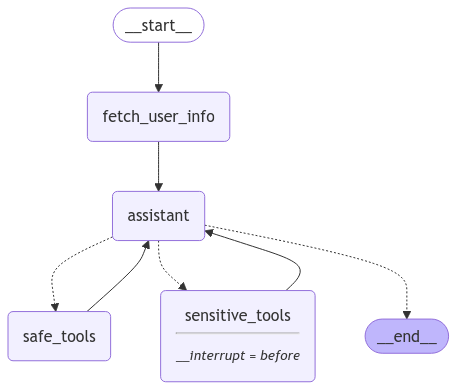

In [17]:
from IPython.display import Image, display

display(Image(
    pt3_graph.get_graph(xray=True).draw_mermaid_png()
))

## Example Conversation

In [19]:
import shutil
import uuid

# Update with the backup file so we can restart from the original place in each section
db = update_dates(db)
thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        # The passenger_id is used in our flight tools to
        # fetch the user's flight information
        "passenger_id": "3442 587242",
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}

tutorial_questions = [
    "Hi there, what time is my flight?",
    "Am i allowed to update my flight to something sooner? I want to leave later today.",
    "Update my flight to sometime next week then",
    "The next available option is great",
    "what about lodging and transportation?",
    "Yeah i think i'd like an affordable hotel for my week-long stay (7 days). And I'll want to rent a car.",
    "OK could you place a reservation for your recommended hotel? It sounds nice.",
    "yes go ahead and book anything that's moderate expense and has availability.",
    "Now for a car, what are my options?",
    "Awesome let's just get the cheapest option. Go ahead and book for 7 days",
    "Cool so now what recommendations do you have on excursions?",
    "Are they available while I'm there?",
    "interesting - i like the museums, what options are there? ",
    "OK great pick one and book it for my second day there.",
]


_printed = set()
# We can reuse the tutorial questions from part 1 to see how it does.
for question in tutorial_questions:
    events = pt3_graph.stream(
        {"messages": ("user", question)}, config, stream_mode="values"
    )
    for event in events:
        _print_event(event, _printed)
    snapshot = pt3_graph.get_state(config)
    while snapshot.next:
        # We have an interrupt! The agent is trying to use a tool, and the user can approve or deny it
        # Note: This code is all outside of your graph. Typically, you would stream the output to a UI.
        # Then, you would have the frontend trigger a new run via an API call when the user has provided input.
        try:
            user_input = input(
                "Do you approve of the above actions? Type 'y' to continue;"
                " otherwise, explain your requested changed.\n\n"
            )
        except:
            user_input = "y"
        if user_input.strip() == "y":
            # Just continue
            result = pt3_graph.invoke(
                None,
                config,
            )
        else:
            # Satisfy the tool invocation by
            # providing instructions on the requested changes / change of mind
            result = pt3_graph.invoke(
                {
                    "messages": [
                        ToolMessage(
                            tool_call_id=event["messages"][-1].tool_calls[0]["id"],
                            content=f"API call denied by user. Reasoning: '{user_input}'. Continue assisting, accounting for the user's input.",
                        )
                    ]
                },
                config,
            )
        snapshot = pt3_graph.get_state(config)

================================ Human Message =================================

Hi there, what time is my flight?
================================== Ai Message ==================================

[{'id': 'toolu_013gk7C1tChL19bkXVhgZJdX', 'input': {}, 'name': 'fetch_user_flight_information', 'type': 'tool_use'}]
Tool Calls:
  fetch_user_flight_information (toolu_013gk7C1tChL19bkXVhgZJdX)
 Call ID: toolu_013gk7C1tChL19bkXVhgZJdX
  Args:
================================= Tool Message =================================
Name: fetch_user_flight_information

[{"ticket_no": "7240005432906569", "book_ref": "C46E9F", "flight_id": 19250, "flight_no": "LX0112", "departure_airport": "CDG", "arrival_airport": "BSL", "scheduled_departure": "2024-11-15 16:55:02.782758-04:00", "scheduled_arrival": "2024-11-15 18:25:02.782758-04:00", "seat_no": "18E", "fare_conditions": "Economy"}]
================================== Ai Message ==================================

Your flight LX0112 from CDG to BSL is sc

One problem with this design is that we are putting a lot of pressure on a single prompt. If we want to add more tools, or if each tool gets more complicated (more filters, more business logic constraining behavior, etc), it's likely the tool usage and overall behavior of the bot will start to suffer.

# Specialized Workflows

Our graph can detect user intents and select the appropriate workflow or "skill" to satisfy the user's needs. Each workflow can focus on its domain, allowing for isolated improvements without degrading the overall assistant.

## State

We want to keep track of which sub-graph is in control at any given moment by tracking it as a dedicated **stack**.

Add a `dialog_state` list to the `State` below. Any time a `node` is run and returns a value for `dialog_state`, the `update_dialog_stack` function will be called to determine how to apply the update.

In [36]:
from typing import Annotated, Literal, Optional
from typing_extensions import TypedDict

from langgraph.graph.message import AnyMessage, add_messages


def update_dialog_stack(left: list[str], right: Optional[str]) -> list[str]:
    """Push or pop the state"""
    if right is None:
        return left
    if right == 'pop':
        return left[:-1]
    return left + [right]


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    user_info: str
    dialog_state: Annotated[
        list[
            Literal[
                'assistant',
                'update_flight',
                'book_car_rental',
                'book_hotel',
                'book_excursion',
            ]
        ],
        update_dialog_stack,
    ]

## Assistants

This time we will create an assistant for **every workflow**. That means:
1. Flight booking assistant
2. Hotel booking assistant
3. Car rental assistant
4. Excursion assistant
5. Primary assistant to route between these

This is an example of the **supervisor** design pattern in the Multi-agent design.

Next, we define the `Runnable` objects to power each assistant. Each `Runnable` has a prompt, LLM, and schemas for the tools scoped to that assistant. Each *specialized* / delegated assistant additionally can call the `CompleteOrEscalate` tool to indicate that the control flow should be passed back to the primary assistant. This happens if it has successfully completed its work or if the user has changed their mind or needs assistance on something that beyond the scope of that particular workflow.

In [37]:
from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig

from pydantic import BaseModel, Field


class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            result = self.runnable.invoke(state)

            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get('text')
            ):
                messages = state['messages'] + [('user', "Respond with a real output.")]
                state = {**state, 'messages': messages}
            else:
                break

        return {'messages': result}


class CompleteOrEscalate(BaseModel):
    """
    A tool to mark the current task as completed and/or to escalate control of
    the dialog to the main assistant, who can re-route the dialog based on
    the user's needs.
    """

    cancel: bool = True
    reason: str

    class Config:
        json_schema_extra = {
            'example': {
                'cancel': True,
                'reason': "User changed their mind about the current task.",
            },
            'example2': {
                'cancel': True,
                'reason': "I have fully completed the task.",
            },
            'example3': {
                'cancel': False,
                'reason': "I need to search the user's emails or calendar for more information.",
            },
        }

In [38]:
# We need a LLM to bind tools with different tools
llm = ChatAnthropic(model='claude-3-sonnet-20240229', temperature=1)

In [39]:
# Flight booking assistant
flight_booking_prompt = ChatPromptTemplate.from_messages(
    [
        (
            'system',
            "You are a specialized assistant for handling flight updates. "
            " The parimary assistant delegates work to you whenever the user needs help updating their bookings."
            " When searching, be persistent. Expand your query bounds if the first search returns no results."
            " If you need more information or the customer changes their mind, escalate the task back to the main assistant."
            " Remember that a booking isn't completed until after the relevant tool has successfully been used."
            "\n\nCurrent user flight information:\n<Flights>\n{user_info}\n</Flights>"
            "\nCurrent time: {time}."
            "\n\nIf the user needs help, and none of your tools are appropriate for it, then"
            " 'CompleteOrEscalate' the dialog to the host assistant. Do not waste the user's time. DO not make up invalid tools or functions."
        ),
        ('placeholder', '{messages}'),
    ]
).partial(time=datetime.now)

# define flight-related tools
update_flight_safe_tools = [search_flights]
update_flight_sensitive_tools = [update_ticket_to_new_flight, cancel_ticket]
update_flight_tools = update_flight_safe_tools + update_flight_sensitive_tools
# define flight runnable
update_flight_runnable = flight_booking_prompt | llm.bind_tools(
    tools=update_flight_tools + [CompleteOrEscalate]
)

In [40]:
# Hotel booking assistant
book_hotel_prompt = ChatPromptTemplate.from_messages(
    [
        (
            'system',
            "You are a specialized assistant for handling hotel bookings."
            " The parimary assistant delegates work to you whenever the user needs help booking a hotel."
            " Search for available hotels based on the user's preferences and confirm the booking details with the customer."
            " When searching, be persistent. Expand your query bounds if the first search returns no results."
            " If you need more information or the customer changes their mind, escalate the task back to the main assistant."
            " Remember that a booking isn't completed until after the relevant tool has successfully been used."
            "\nCurrent time: {time}."
            "\n\nIf the user needs help, and none of your tools are appropriate for it, then 'CompleteOrEscalate' the dialog to the host assistant."
            " Do not waste the user's time. Do not make up invalid tools or functions."
            "\n\nSome examples for which you should CompleteOrEscalate:\n"
            " - 'what's the weather like this time of year?'\n"
            " - 'nevermind I think I'll book separately'\n"
            " - 'I need to figure out transportation while I'm there'\n"
            " - 'oh wait I haven't booked my flight yet I'll do that first'\n"
            " - 'Hotel booking confirmed'"
        ),
        ('placeholder', '{messages}'),
    ]
).partial(time=datetime.now)

# define hotel-related tools
book_hotel_safe_tools = [search_hotels]
book_hotel_sensitive_tools = [book_hotel, update_hotel, cancel_hotel]
book_hotel_tools = book_hotel_safe_tools + book_hotel_sensitive_tools
# define hotel runnable
book_hotel_runnable = book_hotel_prompt | llm.bind_tools(
    tools=book_hotel_tools + [CompleteOrEscalate]
)

In [41]:
# Car rental assistant
book_car_rental_prompt = ChatPromptTemplate.from_messages(
    [
        (
            'system',
            "You are a specialized assistant for handling car rental bookings. "
            "The primary assistant delegates work to you whenever the user needs help booking a car rental. "
            "Search for available car rentals based on the user's preferences and confirm the booking details with the customer. "
            " When searching, be persistent. Expand your query bounds if the first search returns no results. "
            "If you need more information or the customer changes their mind, escalate the task back to the main assistant."
            " Remember that a booking isn't completed until after the relevant tool has successfully been used."
            "\nCurrent time: {time}."
            "\n\nIf the user needs help, and none of your tools are appropriate for it, then "
            '"CompleteOrEscalate" the dialog to the host assistant. Do not waste the user\'s time. Do not make up invalid tools or functions.'
            "\n\nSome examples for which you should CompleteOrEscalate:\n"
            " - 'what's the weather like this time of year?'\n"
            " - 'What flights are available?'\n"
            " - 'nevermind i think I'll book separately'\n"
            " - 'Oh wait i haven't booked my flight yet i'll do that first'\n"
            " - 'Car rental booking confirmed'",
        ),
        ('placeholder', '{messages}'),
    ]
).partial(time=datetime.now)

# define car rental tools
book_car_rental_safe_tools = [search_car_rentals]
book_car_rental_sensitive_tools = [
    book_car_rental,
    update_car_rental,
    cancel_car_rental,
]
book_car_rental_tools = book_car_rental_safe_tools + book_car_rental_sensitive_tools
# define car rental runnable
book_car_rental_runnable = book_car_rental_prompt | llm.bind_tools(
    tools=book_car_rental_tools + [CompleteOrEscalate]
)

In [42]:
# Excursion assistant
book_excursion_prompt = ChatPromptTemplate.from_messages(
    [
        (
            'system',
            "You are a specialized assistant for handling trip recommendations. "
            "The primary assistant delegates work to you whenever the user needs help booking a recommended trip. "
            "Search for available trip recommendations based on the user's preferences and confirm the booking details with the customer. "
            "If you need more information or the customer changes their mind, escalate the task back to the main assistant."
            " When searching, be persistent. Expand your query bounds if the first search returns no results. "
            " Remember that a booking isn't completed until after the relevant tool has successfully been used."
            "\nCurrent time: {time}."
            '\n\nIf the user needs help, and none of your tools are appropriate for it, then "CompleteOrEscalate" the dialog to the host assistant. Do not waste the user\'s time. Do not make up invalid tools or functions.'
            "\n\nSome examples for which you should CompleteOrEscalate:\n"
            " - 'nevermind i think I'll book separately'\n"
            " - 'i need to figure out transportation while i'm there'\n"
            " - 'Oh wait i haven't booked my flight yet i'll do that first'\n"
            " - 'Excursion booking confirmed!'",
        ),
        ('placeholder', '{messages}'),
    ]
).partial(time=datetime.now)

# define excursion tools
book_excursion_safe_tools = [search_trip_recommendations]
book_excursion_sensitive_tools = [book_excursion, update_excursion, cancel_excursion]
book_excursion_tools = book_excursion_safe_tools + book_excursion_sensitive_tools
# define excursion runnable
book_excursion_runnable = book_excursion_prompt | llm.bind_tools(
    tools=book_excursion_tools + [CompleteOrEscalate]
)

In [43]:
# Primary Assistant
class ToFlightBookingAssistant(BaseModel):
    """Transfer work to a specialized assistant to handle flight updates and cancellations."""

    request: str = Field(
        description="Any necessary followup questions the update flight assistant should clarify before proceeding."
    )

class ToBookCarRental(BaseModel):
    """Transfer work to a specialized assistant to handle car rental bookings."""

    location: str = Field(
        description="The location where the user wants to rent a car."
    )
    start_date: str = Field(
        description="The start date of the car rental."
    )
    end_date: str = Field(
        description="The end date of the car rental."
    )
    request: str = Field(
        description="Any additional information or requests from the user regarding the car rental."
    )

    class Config:
        json_schema_extra = {
            'example': {
                'location': "Basel",
                'start_date': '2023-07-01',
                'end_date': '2023-07-05',
                'request': 'I need a compact car with automatic transmission.',
            }
        }


class ToHotelBookingAssistant(BaseModel):
    """Transfer work to a specialized assistant to handle hotel bookings."""

    location: str = Field(
        description="The location where the user wants to book a hotel."
    )
    checkin_date: str = Field(
        description="The check-in date for the hotel."
    )
    checkout_date: str = Field(
        description="The check-out date for the hotel."
    )
    request: str = Field(
        description="Any additional information or requests from the user regarding the hotel booking."
    )

    class Config:
        json_schema_extra = {
            'example': {
                'location': 'Zurich',
                'checkin_date': '2023-08-15',
                'checkout_date': '2023-08-20',
                'request': "I prefer a hotel near the city center with a room that has a view.",
            }
        }


class ToBookExcursion(BaseModel):
    """Transfer work to a specialized assistant to handle trip recommendation and other excursion bookings."""

    location: str = Field(
        description='The location where the user wants to book a recommended trip.'
    )
    request: str = Field(
        description='Any additional information or requests from the user regarding the trip recommendation.'
    )

    class Config:
        json_schema_extra = {
            'example': {
                'location': 'Lucerne',
                'request': 'The user is interested in outdoor activities and scenic views.',
            }
        }

In [44]:
# The top-level assistant performs general Q&A and delegates specialized tasks to other assistants
# The task delegation is a simple form of semantic routing / does simple intent detection
primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            'system',
            "You are a helpful customer support assistant for Swiss Airlines. "
            "Your primary role is to search for flight information and company policies to answer customer queries. "
            "If a customer requests to update or cancel a flight, book a car rental, book a hotel, or get trip recommendations, "
            "delegate the task to the appropriate specialized assistant by invoking the corresponding tool. You are not able to make these types of changes yourself."
            " Only the specialized assistants are given permission to do this for the user."
            "The user is not aware of the different specialized assistants, so do not mention them; just quietly delegate through function calls. "
            "Provide detailed information to the customer, and always double-check the database before concluding that information is unavailable. "
            " When searching, be persistent. Expand your query bounds if the first search returns no results. "
            " If a search comes up empty, expand your search before giving up."
            "\n\nCurrent user flight information:\n<Flights>\n{user_info}\n</Flights>"
            "\nCurrent time: {time}.",
        ),
        ('placeholder', '{messages}'),
    ]
).partial(time=datetime.now)

# define primary assistant tools
primary_assistant_tools = [
    TavilySearchResults(max_results=1),
    search_flights,
    lookup_policy,
]
# define primary assistant runnable
assistant_runnable = primary_assistant_prompt | llm.bind_tools(
    tools=primary_assistant_tools + [
        ToFlightBookingAssistant,
        ToBookCarRental,
        ToHotelBookingAssistant,
        ToBookExcursion,
    ]
)

## Create Assistant

In the previous section, we made the design decision to have a shared `messages` state between all the nodes. This is powerful in that each delegated assistant can see the entire user journey and have a shared context.

However, this means that weaker LLMs can easily get mixed up about there specific scpoe. To mark the "handoff" between the primary assistant and one of the delegated workflows (and complete the tool call from the router), we will add a `ToolMessage` to the state.

## Utility

Create a function to make an "entry" node for each workflow, stating "the current assistant is `assistant_name`".

In [45]:
from typing import Callable

from langchain_core.messages import ToolMessage


def create_entry_node(assistant_name: str, new_dialog_state: str) -> Callable:
    def entry_node(state: State) -> dict:
        tool_call_id = state['messages'][-1].tool_calls[0]['id']
        return {
            'messages': [
                ToolMessage(
                    content=f"The assistant is now the {assistant_name}. Reflect on the above conversation between the host assistant and the user."
                    f" The user's intent is unsatisfied. Use the provided tools to assist the user. Remember, you are {assistant_name},"
                    " and the booking, update, other action is not complete until after you have successfully invoked the appropriate tool."
                    " If the user changes their mind or needs help for other tasks, call the CompleteOrEscalate function to let the primary host assistant take control."
                    " Do not mention who you are - just act as the proxy for the assistant.",
                    tool_call_id=tool_call_id,
                )
            ],
            'dialog_state': new_dialog_state,
        }

    return entry_node

## Define Graph

In [46]:
# We start with a node to pre-populate the state with the user's current information.
from typing import Literal

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import tools_condition

builder = StateGraph(State)

def user_info(state: State):
    return {'user_info': fetch_user_flight_information.invoke({})}


# pre-fetch user's information
builder.add_node('fetch_user_info', user_info)
builder.add_edge(START, 'fetch_user_info')

Now define our specialized workflows.

Each mini-workflow looks very similar to our full graph in the previous section, employing 5 nodes:
1. `enter_*`: use the `create_entry_node` utility we defined above to add a `ToolMessage` signaling that the new specialized assistant is at the helm.
2. Assistant: the prompt + LLM combo that takes in the current state and either uses a tool, asks a question of the user, or ends the workflow (return to the primary assistant).
3. `*_safe_tools`: "read-only" tools the assistant can use without user confirmation.
4. `*_sensitive_tools`: tools with "write" access that require user confirmation (and will be assigned an `interrupt_before` when we compile the graph).
5. `leave_skill`: pop the `dialog_state` to signal that the primary assistant is back in control.


Due to their similarities, we can define a factory function to generate these, but here we will define them each explicitly.

Make the **flight booking assistant** dedicated to managing the user journey for updating and canceling flights.

In [47]:
# Flight Booking Assistant
builder.add_node(
    'enter_update_flight',
    create_entry_node('Flight Updates & Booking Assistant', 'flight_booking'),
)
builder.add_node(
    'update_flight',
    Assistant(update_flight_runnable),
)
builder.add_edge('enter_update_flight', 'update_flight')
builder.add_node(
    'update_flight_sensitive_tools',
    create_tool_node_with_fallback(update_flight_sensitive_tools),
)
builder.add_node(
    'update_flight_safe_tools',
    create_tool_node_with_fallback(update_flight_safe_tools),
)


def route_update_flight(state: State):
    route = tools_condition(state)
    if route == END:
        return END

    tool_calls = state['messages'][-1].tool_calls
    did_cancel = any(tc['name'] == CompleteOrEscalate.__name__ for tc in tool_calls)
    if did_cancel:
        return 'leave_skill'

    safe_toolnames = [t.name for t in update_flight_safe_tools]
    if all(tc['name'] in safe_toolnames for tc in tool_calls):
        return 'update_flight_safe_tools'
    return 'update_flight_sensitive_tools'


builder.add_edge('update_flight_sensitive_tools', 'update_flight')
builder.add_edge('update_flight_safe_tools', 'update_flight')
builder.add_conditional_edges(
    'update_flight',
    route_update_flight,
    [
        'update_flight_sensitive_tools',
        'update_flight_safe_tools',
        'leave_skill',
        END,
    ]
)

In [48]:
# This node will be shared for exiting all specialized assistants
def pop_dialog_state(state: State) -> dict:
    """
    Pop the dialog stack and return to the main assistant.
    This lets the full graph explicitly track the dialog flow
    and delegate control to specific sub-graphs.
    """
    messages = []
    if state['messages'][-1].tool_calls:
        # NOTE: Doesn't currently handle the edge case where the LLM performs parallel tool calls
        messages.append(
            ToolMessage(
                content="Resuming dialog with the host assistant. Please reflect on the past conversation and assist the user as needed.",
                tool_call_id=state['messages'][-1].tool_calls[0]['id'],
            )
        )

    return {
        'dialog_state': 'pop',
        'messages': messages,
    }

In [49]:
# add the leave_skill node
builder.add_node('leave_skill', pop_dialog_state)
builder.add_edge('leave_skill', 'primary_assistant')

Next, create the **car rental assistant** graph

In [50]:
# Car Rental Assistant
builder.add_node(
    'enter_book_car_rental',
    create_entry_node('Car Rental Assistant', 'book_car_rental'),
)
builder.add_node(
    'book_car_rental',
    Assistant(book_car_rental_runnable),
)
builder.add_edge('enter_book_car_rental', 'book_car_rental')
builder.add_node(
    'book_car_rental_sensitive_tools',
    create_tool_node_with_fallback(book_car_rental_sensitive_tools),
)
builder.add_node(
    'book_car_rental_safe_tools',
    create_tool_node_with_fallback(book_car_rental_safe_tools),
)


def route_book_car_rental(state: State):
    route = tools_condition(state)

    if route == END:
        return END

    tool_calls = state['messages'][-1].tool_calls
    did_cancel = any(tc['name'] == CompleteOrEscalate.__name__ for tc in tool_calls)
    if did_cancel:
        return 'leave_skill'

    safe_toolnames = [t.name for t in book_car_rental_safe_tools]
    if all(tc['name'] in safe_toolnames for tc in tool_calls):
        return 'book_car_rental_safe_tools'
    return 'book_car_rental_sensitive_tools'


builder.add_edge('book_car_rental_sensitive_tools', 'book_car_rental')
builder.add_edge('book_car_rental_safe_tools', 'book_car_rental')
builder.add_conditional_edges(
    'book_car_rental',
    route_book_car_rental,
    [
        'book_car_rental_sensitive_tools',
        'book_car_rental_safe_tools',
        'leave_skill',
        END,
    ]
)

Then define the **hotel booking asisstant**

In [51]:
# Hotel Booking Assistant
builder.add_node(
    "enter_book_hotel", create_entry_node("Hotel Booking Assistant", "book_hotel")
)
builder.add_node("book_hotel", Assistant(book_hotel_runnable))
builder.add_edge("enter_book_hotel", "book_hotel")
builder.add_node(
    "book_hotel_safe_tools",
    create_tool_node_with_fallback(book_hotel_safe_tools),
)
builder.add_node(
    "book_hotel_sensitive_tools",
    create_tool_node_with_fallback(book_hotel_sensitive_tools),
)


def route_book_hotel(
    state: State,
):
    route = tools_condition(state)
    if route == END:
        return END
    tool_calls = state["messages"][-1].tool_calls
    did_cancel = any(tc["name"] == CompleteOrEscalate.__name__ for tc in tool_calls)
    if did_cancel:
        return "leave_skill"
    tool_names = [t.name for t in book_hotel_safe_tools]
    if all(tc["name"] in tool_names for tc in tool_calls):
        return "book_hotel_safe_tools"
    return "book_hotel_sensitive_tools"


builder.add_edge("book_hotel_sensitive_tools", "book_hotel")
builder.add_edge("book_hotel_safe_tools", "book_hotel")
builder.add_conditional_edges(
    "book_hotel",
    route_book_hotel,
    ["leave_skill", "book_hotel_safe_tools", "book_hotel_sensitive_tools", END],
)

Then, define the **excursion assistant**

In [52]:
# Excursion Assistant
builder.add_node(
    "enter_book_excursion",
    create_entry_node("Trip Recommendation Assistant", "book_excursion"),
)
builder.add_node("book_excursion", Assistant(book_excursion_runnable))
builder.add_edge("enter_book_excursion", "book_excursion")
builder.add_node(
    "book_excursion_safe_tools",
    create_tool_node_with_fallback(book_excursion_safe_tools),
)
builder.add_node(
    "book_excursion_sensitive_tools",
    create_tool_node_with_fallback(book_excursion_sensitive_tools),
)


def route_book_excursion(
    state: State,
):
    route = tools_condition(state)
    if route == END:
        return END
    tool_calls = state["messages"][-1].tool_calls
    did_cancel = any(tc["name"] == CompleteOrEscalate.__name__ for tc in tool_calls)
    if did_cancel:
        return "leave_skill"
    tool_names = [t.name for t in book_excursion_safe_tools]
    if all(tc["name"] in tool_names for tc in tool_calls):
        return "book_excursion_safe_tools"
    return "book_excursion_sensitive_tools"


builder.add_edge("book_excursion_sensitive_tools", "book_excursion")
builder.add_edge("book_excursion_safe_tools", "book_excursion")
builder.add_conditional_edges(
    "book_excursion",
    route_book_excursion,
    ["book_excursion_safe_tools", "book_excursion_sensitive_tools", "leave_skill", END],
)

Finally create the **primary assistant**

In [53]:
# Primary Assistant
builder.add_node('primary_assistant', Assistant(assistant_runnable))
builder.add_node(
    'primary_assistant_tools',
    create_tool_node_with_fallback(primary_assistant_tools)
)


def route_primary_assistant(state: State):
    route = tools_condition(state)

    if route == END:
        return END

    tool_calls = state['messages'][-1].tool_calls
    if tool_calls:
        if tool_calls[0]['name'] == ToFlightBookingAssistant.__name__:
            return 'enter_update_flight'
        elif tool_calls[0]['name'] == ToBookCarRental.__name__:
            return 'enter_book_car_rental'
        elif tool_calls[0]['name'] == ToHotelBookingAssistant.__name__:
            return 'enter_book_hotel'
        elif tool_calls[0]['name'] == ToBookExcursion.__name__:
            return 'enter_book_excursion'
        return 'primary_assistant_tools'
    raise ValueError('Invalid route')



# The assistant can route to one of the delegated assistants,
# directly use a tool, or directly respond to the user
builder.add_conditional_edges(
    'primary_assistant',
    route_primary_assistant,
    [
        'enter_update_flight',
        'enter_book_car_rental',
        'enter_book_hotel',
        'enter_book_excursion',
        'primary_assistant_tools',
        END,
    ]
)
builder.add_edge('primary_assistant_tools', 'primary_assistant')



# Each delegated workflow can directly respond to the user
# When the user responds, we want to return to the currently active workflow
def route_to_workflow(state: State) ->\
Literal[
    'primary_assistant',
    'update_flight',
    'book_car_rental',
    'book_hotel',
    'book_excursion',
]:
    """If we are in a delegated state, route directly to the appropriate assistant"""
    dialog_state = state.get('dialog_state')
    if not dialog_state:
        return 'primary_assistant'
    return dialog_state[-1]


builder.add_conditional_edges('fetch_user_info', route_to_workflow)

In [54]:
# Compile graph
memory = MemorySaver()
pt4_graph = builder.compile(
    checkpointer=memory,
    # Let the user approve or deny the use of sensitive tools
    interrupt_before=[
        'update_flight_sensitive_tools',
        'book_car_rental_sensitive_tools',
        'book_hotel_sensitive_tools',
        'book_excursion_sensitive_tools',
    ],
)

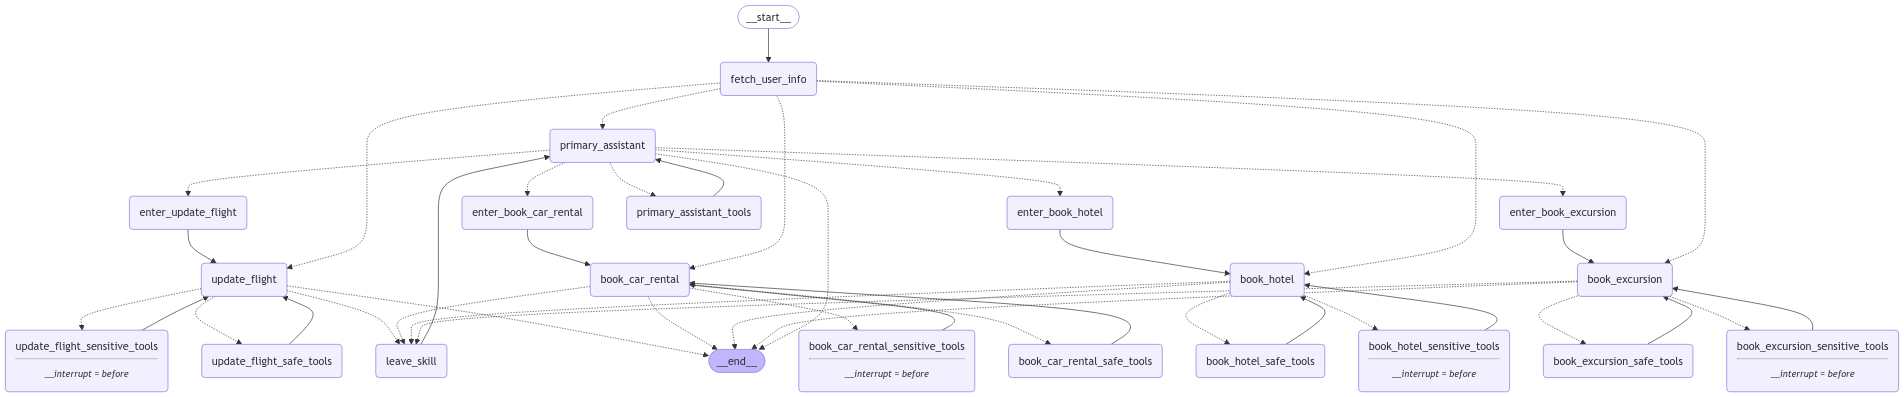

In [55]:
from IPython.display import Image, display

display(Image(
    pt4_graph.get_graph(xray=True).draw_mermaid_png()
))

## Conversation

In [57]:
# Let's create an example conversation a user might have with the assistant
tutorial_questions = [
    "Hi there, what time is my flight?"
    "Am i allowed to update my flight to something sooner? I want to leave later today.",
    "Update my flight to sometime next week then",
    "The next available option is great",
    "what about lodging and transportation?",
    "Yeah i think i'd like an affordable hotel for my week-long stay (7 days). And I'll want to rent a car.",
    "OK could you place a reservation for your recommended hotel? It sounds nice.",
    "yes go ahead and book anything that's moderate expense and has availability.",
    "Now for a car, what are my options?",
    "Awesome let's just get the cheapest option. Go ahead and book for 7 days",
    "Cool so now what recommendations do you have on excursions?",
    "Are they available while I'm there?",
    "interesting - i like the museums, what options are there? ",
    "OK great pick one and book it for my second day there.",
]

In [59]:
import shutil
import uuid

# Update with the backup file so we can restart from the original place in each section
db = update_dates(db)
thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        # The passenger_id is used in our flight tools to
        # fetch the user's flight information
        "passenger_id": "3442 587242",
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}

_printed = set()
# We can reuse the tutorial questions from part 1 to see how it does.
for question in tutorial_questions:
    events = pt4_graph.stream(
        {"messages": ("user", question)}, config, stream_mode="values"
    )
    for event in events:
        _print_event(event, _printed)
    snapshot = pt4_graph.get_state(config)
    while snapshot.next:
        # We have an interrupt! The agent is trying to use a tool, and the user can approve or deny it
        # Note: This code is all outside of your graph. Typically, you would stream the output to a UI.
        # Then, you would have the frontend trigger a new run via an API call when the user has provided input.
        try:
            user_input = input(
                "Do you approve of the above actions? Type 'y' to continue;"
                " otherwise, explain your requested changed.\n\n"
            )
        except:
            user_input = "y"
        if user_input.strip() == "y":
            # Just continue
            result = pt4_graph.invoke(
                None,
                config,
            )
        else:
            # Satisfy the tool invocation by
            # providing instructions on the requested changes / change of mind
            result = pt4_graph.invoke(
                {
                    "messages": [
                        ToolMessage(
                            tool_call_id=event["messages"][-1].tool_calls[0]["id"],
                            content=f"API call denied by user. Reasoning: '{user_input}'. Continue assisting, accounting for the user's input.",
                        )
                    ]
                },
                config,
            )
        snapshot = pt4_graph.get_state(config)

================================ Human Message =================================

Hi there, what time is my flight?Am i allowed to update my flight to something sooner? I want to leave later today.
================================== Ai Message ==================================

[{'id': 'toolu_01M6VUMBi2siLEbPbg6RvbuY', 'input': {'query': 'swiss airlines flight 7240005432906569'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Tool Calls:
  tavily_search_results_json (toolu_01M6VUMBi2siLEbPbg6RvbuY)
 Call ID: toolu_01M6VUMBi2siLEbPbg6RvbuY
  Args:
    query: swiss airlines flight 7240005432906569
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.flightaware.com/live/flight/SWR9", "content": "Track Swiss (LX) #9 flight from Chicago O'Hare Intl to Zurich (Kloten) Flight status, tracking, and historical data for Swiss 9 (LX9/SWR9) including scheduled, estimated, and actual departure and arri

BadRequestError: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'Your credit balance is too low to access the Anthropic API. Please go to Plans & Billing to upgrade or purchase credits.'}}

We have developed a customer support bot that handles diverse tasks using focused workflows. We have learned to use some of LangGraph's core features to design and refactor an application based on our product needs.